## Topic Extraction for customer reviews
#### This notebook discusses trends in a customer reviews in Brazilian E-Commerce Public Dataset. It explores a basic EDA of customer reviews and then moves on towards exploring different topic extraction techniques.We will use wordcloud for getting top words and NLTK and sklearn for topic extraction techniques

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.decomposition.nmf import _beta_divergence 
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import metrics
import nltk
from sklearn.cluster import KMeans
from nltk.stem import RSLPStemmer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from translate import Translator
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

Let's start with basic overview of what we are going to cover in the notebook and move on to analyze the dataset.
#### What is topic extraction?
Topic extraction or Topic Modelling is a method to extract central keywords or cluster of words from the large text based on frequency and linguistic patterns in the text, ranking them according to their relative importance.

We will explore two different topic extraction techniques in this notebook.

1. **pLSA (Probabilistic Latent Semantic Analysis)**
    - Model evaluation by using reconstruction error
2. **LDA (Latent Dirichlet Allocation)**
    - Model evaluation using perplexity and log-likelihood

Detailed desciptions and their workings are explained in [this article](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05)
We will find the best models of each method using GridSearch to fit models and look into convergence of each model for number of topics.

Later, we can compare results with a clustering algorithm and crossverify if we have similar number of clusters as topic extraction techniques.

We will use pandas dataframe and plot.ly for exploring the dataset.

In [2]:
#load dataset
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

In [3]:
reviews.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
reviews.describe()

,review_score
count,100000.000000
mean,4.070890
std,1.359663
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


There are total 100,000 records for review scores with some null values. Let's find out how many values can be used for nlp.

In [5]:
# check for null values
reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

There are total 41753 reviews text we can use for the analyis.<br/> No values are missing from Review Score columns. Let's see how review scores are distributed.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


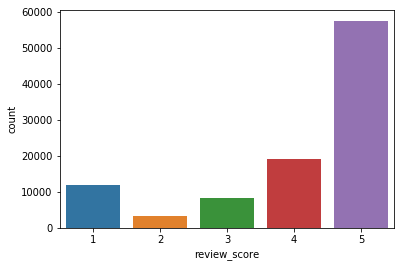

In [6]:
#plot a bar chart with review_score on x axis and count on y axis
ax = sns.countplot(x="review_score", data=reviews)

It shows majority of reviews with 5 score and lesser with 2 score. <br/>
Let's get rid of NaN values and then see how these reviews are spread across the ratings.

In [7]:
#drop all null values from review_comments and design new frame
cleaned_reviews = reviews[['review_score','review_comment_message']].dropna()

In [8]:
cleaned_reviews.shape

(41753, 2)

In [9]:
cleaned_reviews.groupby('review_score').count()

,review_comment_message
review_score,
1,9179
2,2229
3,3665
4,6034
5,20646


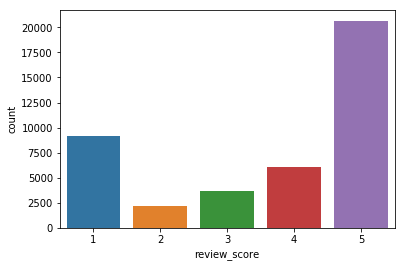

In [10]:
#plot a bar chart with review_score on x axis and count on y axis
ax = sns.countplot(x="review_score", data=cleaned_reviews)

The pattern remains similar and shows customer will write a review if they like their order.<br/>
Almost 50% (~ 49.44%) reviews were for 5 review_score while lowest percentage is 5.34% for review_score 2

We can make a wordcloud to find out which are most frequent words in these reviews.<br/> We will use wordcloud library for this. 

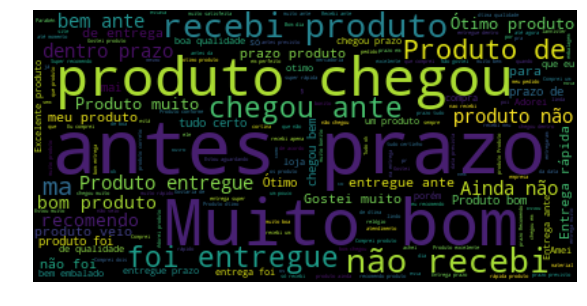

In [11]:
#create a word cloud of all review comments
wordcloud = WordCloud().generate(cleaned_reviews[['review_comment_message']].to_string(index = False,header = False))
plt.figure(figsize=(25, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

Let's find out what are most used words in these reviews.
> mutio bom : Very good

> antes prazo : Before term

> producto chegou: Product arrived

These are about delivery or quality.<br/> Let's check which words dominate for lowest and highest count on reviews, to explore it further

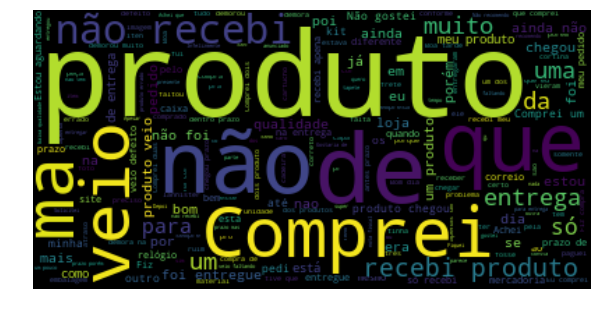

In [12]:
# Create a dataframe of all review_comments with review_score=2
data2 = cleaned_reviews.loc[cleaned_reviews['review_score']==2]

#create a word cloud
wordcloud = WordCloud().generate(data2[['review_comment_message']].to_string(index = False,header = False))
plt.figure(figsize=(10, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

This is wordcloud for all reviews with review_score 2. The cloud doesnot indicate anything about preferred topics, but there are a few words about delivery of the product

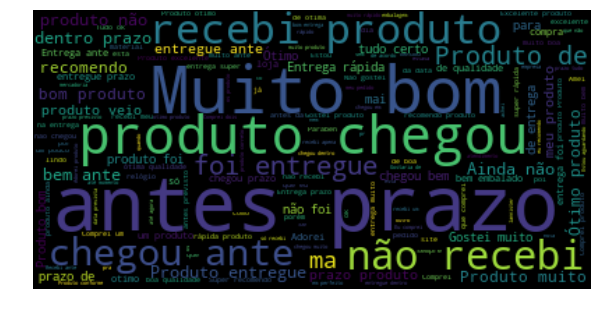

In [13]:
# Create a dataframe of all review_comments with review_score 5
data5 = cleaned_reviews.loc[cleaned_reviews['review_score']==5]

# Create a wordcloud
wordcloud = WordCloud().generate(cleaned_reviews[['review_comment_message']].to_string(index = False,header = False))
plt.figure(figsize=(10,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

This wordcloud is more conclusive, with more deducable words regarding delivery system. But a few about recommending products as well

To make a topic extraction model we will follow these steps:
1. Clean data with help of regular expressions.
    - Symbols and non-english characters
    - Carriage returns and other white spaces
    - Numbers
2. Stem the data
    - Removing the commoner morphological and inflexional endings from words
    - NLTK RSLP is a stemmer for portuguese words
3. Tokenize the data
    - Chopping up a given stream of text or character sequence into words, phrases
    - Use Regex to get rid of unwanted characters passed through cleaning process
4. Create a normalized vectors for the model
    - **VECTORIZER** : Vectorizer turns a collection of text documents into numerical feature vectors. There are different vectorizers available in sklearn library however their techniques are different.
    - Max_features to decide a vocab size and other parameters like lowercase or regex etc.
    - **Stopwords** :most common words in a language which are filtered out for processing
    - sklearn has their own English stopwords, however we will use NLTK portuguese stopwords 
    - ***countvectorizer*** is optimal chocie for LDA because it linearly counts words and creates a vector.
    - ***tfdifvectorizer*** is optimal choice for pSLA (NMF) because it creates a tf(t,d)×idf(t)matrix. Tf means term-frequency in document while idf means inverse document-frequency.


In [14]:
# Create a translator object to translate words to english
translator= Translator(from_lang="portuguese",to_lang="english")

# Download stopwords from nltk
nltk.download('stopwords')

# Download portuguese Stemmer from nltk
nltk.download('rslp')

# collecting portuguese stopwords
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anuja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Anuja\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [15]:
#create a new dataframe with review_comments
review = cleaned_reviews[['review_comment_message']]

#Convert it to string and clean it to remove newlines and other symbols
cleaned_text = review.to_string(index = False,header = False).replace('\n','').replace('\\n','').replace('\\r','').replace('.',' ').replace('?',' ').replace('/"',' ').replace('\\','').strip()

The reason behind using replace instead of using regex is text will be split into a character array instead of text block.<br/> We can use regex at tokenization step and skip this one.<br/>
**NOTE: Do not remove special characters from the text. It will accidently cut words and add noise into our dataframe**

In [16]:
cleaned_text

'Recebi bem antes do prazo estipulado Parabéns lojas lannister adorei comprar pela I   aparelho eficiente  no site a marca do aparelh     Mas um pouco ,travando   pelo valor ta Boa Vendedor confiável, produto ok e entrega antes   GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E                                             Péssimo                                     Loja nota 10            obrigado pela atençao amim dispensadaA compra foi realizada facilmente A entreg                      relógio muito bonito e barato               Não gostei ! Comprei gato por lebreSempre compro pela Internet e a entrega ocorre   Recebi exatamente o que esperava  As demais en                                         Recomendo ,                                       muito boa Tô completamente apaixonada, loja super respon                        Nada de chegar o meu pedido                        Muito bom  muito cheiroso otimo vendedor chegou ate antes do prazo , ado           Processo de compra tranquilo e 

In [17]:
#create stemmer object and stem the text

st = RSLPStemmer()
cleaned_text = st.stem(cleaned_text)

In [18]:
#create tokenizer object and get rid of all digits

tokenizer = RegexpTokenizer('[a-zA-Z]+')
wordsData = tokenizer.tokenize(cleaned_text)

In [19]:
# Create countvectorizer object with top 150 features with max probab 0.96
count_vectorizer = CountVectorizer(max_features = 150,max_df=0.96,stop_words = stopwords)

#create normalized vector
count_vectorized_data = count_vectorizer.fit_transform(wordsData) 

In [20]:
#create LDA model with 5 topics and 10 iterations

lda = LatentDirichletAllocation(n_components=5, max_iter=10,learning_method='online',batch_size= 32,
                                      evaluate_every = 2,verbose = 1)
print(lda)

LatentDirichletAllocation(batch_size=32, doc_topic_prior=None,
             evaluate_every=2, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)


In [21]:
#fit the data

lda_output = lda.fit_transform(count_vectorized_data)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10, perplexity: 69.8429
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10, perplexity: 69.7495


We interpret the model performance using its liklyhood and Perplexity values. 
Greater liklyhood values are better while perplexity should be lesser. 
Formula to calculate perplexity is exp(-1. * log-likelihood per word).<br/> Since we pass tokenzied frame to the model, usaully perplexity values are not a good measure for model evaluation

In [22]:
print("Log Likelihood: ", lda.score(count_vectorized_data))
print("Perplexity: ", lda.perplexity(count_vectorized_data))

Log Likelihood:  -448423.79958518693
Perplexity:  69.74948043061077


In [23]:
#A function to return top n words from given model.
## parameters: 
### model: topic_model, feature_names: vectorizer.getFeatureNames()

def print_top_words(model, feature_names, n_top_words):
    words = []
    for topic_idx, topic in enumerate(model.components_):
        message = ""
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        words.append(message)
        print(message)
    print()
    return words

In [24]:
#print top 5 words in each topic extracted by LDA

lda_topics = print_top_words(model = lda, feature_names = count_vectorizer.get_feature_names(),n_top_words = 5)

comprei qualidade gostei excelente dentro
recebi timo ainda super pida
prazo entrega veio loja sempre
produto compra previsto lannister data
antes chegou bom entregue bem



### Translation

Bought excellent quality liked inside <br/>
I got Timo still super quick <br/>
Deadline delivery came shop always <br/>
Product purchase predicted Lannister date <br/>
Before arrived good delivered well <br/>
<br/>
We can see that even though we got distict words, we still cannot seggregate them into distinct topic.
However, 
Let's implement gridserach to get the best LDA model


In [26]:
#Set dynamic parameters
search_params = {'max_iter':[20,33,60]}

#create a LDA model with static parameters
blank_lda_model = LatentDirichletAllocation(learning_method='online',n_components=2,total_samples=50000,learning_decay=0.43,batch_size=4000)

#Add the blank model as an estimator in GridSearch
LDA_GridSearch = GridSearchCV(blank_lda_model, param_grid=search_params, verbose=1)

LDA_GridSearch.fit(count_vectorized_data)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 82.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=4000, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.43,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=2, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None, total_samples=50000,
             verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_iter': [20, 33, 60]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [ ]:
# best_lda_model = LatentDirichletAllocation(verbose=1,learning_method='online',batch_size = 700,total_samples=50000,learning_decay=0.46,n_components=2,max_iter=25)
#  

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=4000, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.43,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=2, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None, total_samples=50000,
             verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_iter': [20, 33, 60]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [40]:
# Best Model
best_lda_model = LDA_GridSearch.best_estimator_

# Model Parameters
print("Best Model's Params: ", LDA_GridSearch.best_params_)

output = best_lda_model.fit_transform(count_vectorized_data)

# Log Likelihood Score
print("Best Log Likelihood Score: ", best_lda_model.score(count_vectorized_data))

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(count_vectorized_data))


Best Model's Params:  {'max_iter': 20}
Best Log Likelihood Score:  -447139.47557181714
Model Perplexity:  68.90661536338676


In [79]:
#get top 10 words from created topics

best_lda_model_topics = print_top_words(model = best_lda_model, feature_names = count_vectorizer.get_feature_names(),n_top_words = 10)

prazo antes veio bem comprei qualidade gostei ainda excelente loja
produto entrega chegou recebi bom entregue recomendo tudo timo super



### Translation:
**Topic 0:** Deadline before good well bought quality liked yet excellent store <br/>
**Topic 1:** Delivery product arrived received came delivered recommend all Time Super

**NOTE: This is translated using google search, not using translator API**

It shows that modelis successful in dividing our reviews in two different topics. One is appreciation about delivery system and another is appreciation regarding the product quality. 

Let's see if our topics are well segregated or not using pyLDAvis graph.


In [44]:
#PLot a graph of created topics

panel = pyLDAvis.sklearn.prepare(best_lda_model, count_vectorized_data, count_vectorizer)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [46]:
pyLDAvis.display(panel)

They look pretty well seggregated.<br/> Let's validate our results using another topic modelling technique called pLSA.

In sklean we can implement pLSA using NMF with beta-loss function as 'kullback-leibler'.<br/>It assumes that the data and the assigned weights are non-negative. It applies matrix multiplication technique on input corpus,it works better with TfidfVectorizer than CountVectorizer.
Hence we will create a different vectorizer for it and then pass the vectorizer output to the model.

In [52]:
#create a document matrix using tfidf vectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95,max_features=150,stop_words=stopwords)
tfidf_vectorized_data = tfidf_vectorizer.fit_transform(wordsData)

In [54]:
# create a pLSA model

pLSA = NMF(n_components=5,beta_loss='kullback-leibler', solver='mu', max_iter=100, alpha=.1,l1_ratio=.5,verbose = True)

In [56]:
pLSA

NMF(alpha=0.1, beta_loss='kullback-leibler', init=None, l1_ratio=0.5,
  max_iter=100, n_components=5, random_state=None, shuffle=False,
  solver='mu', tol=0.0001, verbose=True)

In [58]:
#fit the model

pLSA_output = pLSA.fit_transform(tfidf_vectorized_data)

Epoch 10 reached after 0.702 seconds, error: 1315.946162
Epoch 20 reached after 1.395 seconds, error: 1315.946162


We interpret the model performance using its reconstruction error. 
Reconstruction error talks about the differnce between between training-data and the dot product WH.
where H is dictinory or vocab of the model and W is transformed data.

It is measure of difference between probability distributions that satisfies some features, which are the canonical extension to our dataset. 

The goal is to minimize reconstruction error.

In [60]:
print("Reconstruction err:", pLSA.reconstruction_err_ )

Reconstruction err: 1315.9461623168315


In [62]:
#print top 5 words from created topics

pLSA_topics = print_top_words(model = pLSA, feature_names = tfidf_vectorizer.get_feature_names(),n_top_words = 5)

produto vou dia empresa embalagem
prazo gostei loja frete dia
entrega compra boa diferente entregaram
antes tudo qualidade ainda super
chegou veio timo excelente pedido



### Translation

Product little day packing company <br/>
Long-term liked day freight store <br/>
Delivery different good buy delivered <br/>
Before everything still super quality <br/>
Arrived came Timo Excellent request <br/>
<br/>

We observe similar results as of the first LDA model. We can get gist about either Quality or timeframe of dilivery of items. However, the distinction is not clear.<br/> 
Since there is no score function for NMF fit method and customized score function would not work for it because we don't have any y values. It will require overloading fit() method.<br/> So let's tune it manually.

Fixed parameters: beta_loss='kullback-leibler'and solver='mu'<br/>This setting of the NMF model to work as a pLSA model. 
Other tunable parameters are 'l1_ratio' and 'init'. <br/>
- 'l1_ratio' is regularization mixing parameter. It should be between 0 and 1.
- 'init' used to initialize the procedure. I have listed available options and their descriptions are available on sklearn documentation.<br/>‘random’ | ‘nndsvd’ | ‘nndsvda’ | ‘nndsvdar’ | ‘custom’ <br/> Default is *'nndsvd'*

In [81]:
#create a blank list to store reconn_err
reconn_err =[]

#blank list to store better model
model= []

#create a list of max_iter attribute
max_iter = [750,1000,2500,4000,5000,6000,7500,10000,15000,25000,30000,40000]

#run a loop to find out reconn_err of each model and add it in the list
for itr in max_iter:
    print("Running for iter:",itr)
    blank_pLSA_model = NMF(beta_loss='kullback-leibler',l1_ratio=0.41,solver='mu',verbose=2,max_iter=itr,n_components=2)
    reconn_err.append(blank_pLSA_model.fit(tfidf_vectorized_data).reconstruction_err_)
    model.append(blank_pLSA_model)

Running for iter: 750
Epoch 10 reached after 0.416 seconds, error: 1540.015156
Epoch 20 reached after 0.824 seconds, error: 1540.015156
Running for iter: 1000
Epoch 10 reached after 0.395 seconds, error: 1550.179888
Epoch 20 reached after 0.779 seconds, error: 1550.179888
Running for iter: 2500
Epoch 10 reached after 0.417 seconds, error: 1537.090110
Epoch 20 reached after 0.834 seconds, error: 1537.090110
Running for iter: 4000
Epoch 10 reached after 0.384 seconds, error: 1528.484609
Epoch 20 reached after 0.760 seconds, error: 1528.484609
Running for iter: 5000
Epoch 10 reached after 0.404 seconds, error: 1524.609505
Epoch 20 reached after 0.809 seconds, error: 1524.609505
Running for iter: 6000
Epoch 10 reached after 0.374 seconds, error: 1523.606894
Epoch 20 reached after 0.763 seconds, error: 1523.606894
Running for iter: 7500
Epoch 10 reached after 0.412 seconds, error: 1576.326113
Epoch 20 reached after 0.820 seconds, error: 1576.326113
Running for iter: 10000
Epoch 10 reached a

In [82]:
#findout min reconn_err and get the best model

index = reconn_err.index(min(reconn_err))
opt_itr = max_iter[index]
print(opt_itr)

6000


In [83]:
#fit data

final_pLSA_model = model[index]
pLSA_output = final_pLSA_model.fit_transform(tfidf_vectorized_data)

Epoch 10 reached after 0.413 seconds, error: 1555.709611
Epoch 20 reached after 0.822 seconds, error: 1555.709611


In [84]:
#print reconn_err

print("Reconstruction err:", final_pLSA_model.reconstruction_err_ )

Reconstruction err: 1555.7096107038833


In [85]:
#print top 5 words from created topic cluster

final_pLSA_topics = print_top_words(model = final_pLSA_model, feature_names = tfidf_vectorizer.get_feature_names(),n_top_words = 5)

produto vou dia empresa embalagem
prazo tudo qualidade timo excelente



### Translation 

Product little day packing company <br/>
Deadline all excellent Time quality <br/>

Keep in mind, some of the context is lost in the translation. We can apply translate on each word while we are extracting these words, but it is time consuming process.

## Conclusion:

- **With reconstruction error ~1556 we can not say it is a good model, however, in light of the LDA model with likelyhood -447139.47557181714, it is a better of two.**

- **With LDA model, we get good clusters. But since we are using count vectorizers it picks up more frequently used adjectives than pLSA. Also, the context is lost in count vectorizer.**
- **According to online sources, LDA is useful for large datasets whereas pLSA works better with smaller ones.**


## Next Steps:

Both of these models can be further used to predict topics for recent reviews.<br/> we will have to follow the same process:<br/>
***Tokenize() –> Stemming() –> vectorizering() –> best_model.predict()***

Another topic modelling approach is **lda2vec** It is a Deep learning approach for LDA. <br/> It combines LDA tecnique with the Word2Vec approach.<br/>LDA deals with words and documents globally, and Word2Vec locally (depending on adjacent words in the training data).<br/> A LDA vector is so sparse that the users can interpret the topic easily, but it is inflexible. Word2Vec’s representation is not human-interpretable, but it is easy to use.

What is differnce between clustering and and topic modelling?<br/>
**TOPIC MODELLING** : The presumptive likelihood of words occurring in specific patterns, relative to some topic and to observe the frequency with which those words are used<br/>
**CLUSTERING** : The presumptive similarities between some set of objects to create groupings inside that set. These groupings (clusters) are indexed based on some imposed scale of similarity and differentiated based on some imposed boundary.

Let's perform simple clustering algorithm on our cleaned data and find out results. <br/>
Process of clustering is similar
- Get vectorized form of the data using vectorizer.
- Apply feature selection algorithm. Here we apply PCA algorithm
- Cluster the feature set. 

This is a basic clustering code sequence explained on sklearn documentation. Since we are not going deeper into clustering, I will not evaluate this model. 
However, if you want to analyze and tune it further, you can use metric.silhouette_score.<br/>
Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b)

In [70]:
#create a vectorizer to take top 100 features
vectorizer = TfidfVectorizer(max_features=100, ngram_range=(2, 4),
                             stop_words=stopwords)

vectorizer.fit(cleaned_reviews['review_comment_message'])

#convert data into a matrix form
X = vectorizer.transform(cleaned_reviews['review_comment_message'])

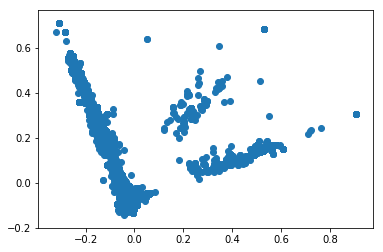

In [71]:
#create a simple PCA model for dimentionality reduction

pca = PCA(n_components=2, random_state=50)
pca.fit(X.toarray())

#get reduced data
X_pca = pca.transform(X.toarray())

#plot transformed data
plt.scatter(X_pca[:, 0], X_pca[:, 1]);

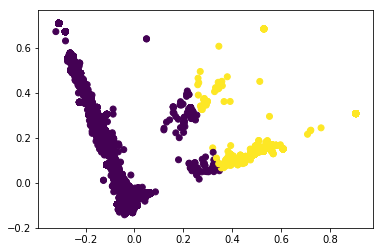

In [72]:
#create a simple kMeans clustering model
model = KMeans(2)

#fit the model and predict labels
predicted = model.fit_predict(X_pca)

#plot the data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted);

In [73]:
#print cluster centers

model.cluster_centers_

array([[-0.03148732, -0.01082122],
       [ 0.69445964,  0.23866443]])

In [74]:
labels = model.labels_

In [75]:
#calculate silhouette_score
# metrics.silhouette_score(X_pca, labels, metric='euclidean')

So, despite of our topic modelling giving us 2 different topics covered in reviews, clustering gives us mixed clusters.<br/> If we examine our topics closely, we can observe reviews are talking about *Good Delivery* or *Good quality product* ot *bad delivery* or *bad product*.<br/>
clustering algorithm tries to clusterize these adjectives as another cluster, mixing words with delivery and product. <br/>
Since some reviews talk about both product as well as delivery, those are overlapped.<br/>

Our outputs from topic models is also a feature selection vector. It follows similar process and we extract those features instead of giving those to clustering algorithms.<br/>
Let's give our output of pLSA algorithm to kMeans clustering and find out if results are different. 

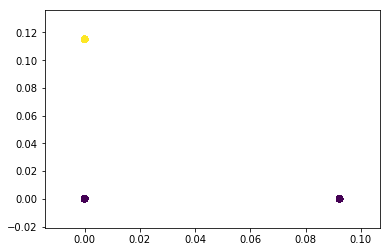

In [77]:
#fit kmeans model to output of best_pLSA_model

pLSA_op = KMeans(2).fit_predict(pLSA_output)
plt.scatter(pLSA_output[:, 0], pLSA_output[:, 1], c=pLSA_op);

We can see, we still have three clusters, however these are well seperated. This is because we applied probablistic formula on it to group together similar words beforehand.<br/>
It still seggregates our 2 topics into three clusters. However, it has distinct and really short clusters because of reduced input data.

Similiar behaviour can be observed if we use  LDA_output to compare cluster results.

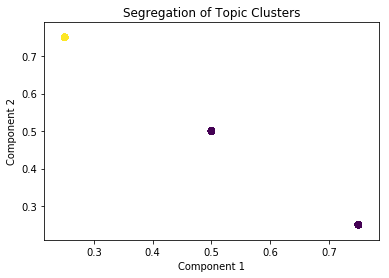

In [78]:
#fit kMeans model to output of best_LDA_models
ldaOP = KMeans(2).fit_predict(output)

#plot data
plt.scatter(output[:, 0], output[:, 1], c=ldaOP);


We can confirm our conclusion about outputs of LDA and pLSA models from these clusters as well.<br/>
Clusters formed with pLSA models are well seggregated and almost equidistant from eachother <br/>
Clusters formed with LDA models are superimposed and form a stright line

Let's find out top words in the cluster of reviews

In [90]:
#add cluster label to dataframe

cleaned_reviews['kMeans'] =  predicted

cleaned_reviews.head(5)

,review_score,review_comment_message,kMeans
3,5,Recebi bem antes do prazo estipulado.,0
4,5,Parabéns lojas lannister adorei comprar pela I...,0
9,4,aparelho eficiente. no site a marca do aparelh...,0
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",0
15,5,"Vendedor confiável, produto ok e entrega antes...",0


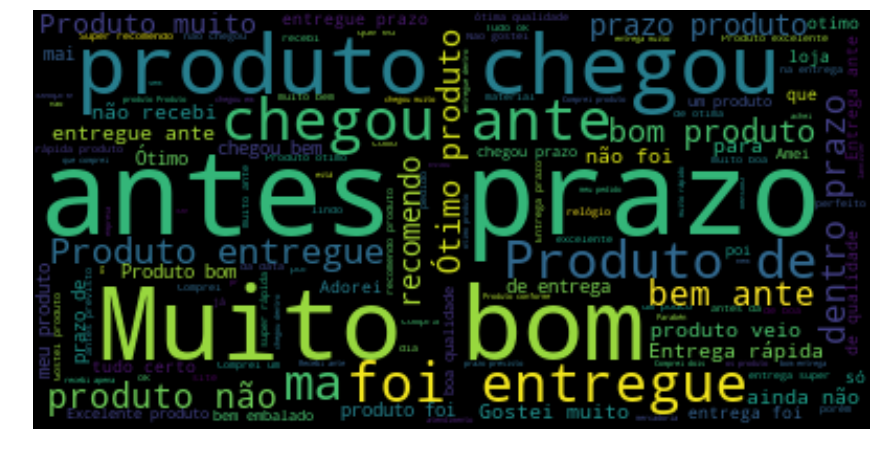

In [92]:
#create dataframe of cluster 0 review_comments
text = cleaned_reviews[cleaned_reviews['kMeans'] == 0]['review_comment_message'].to_string()

#create wordcloud
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

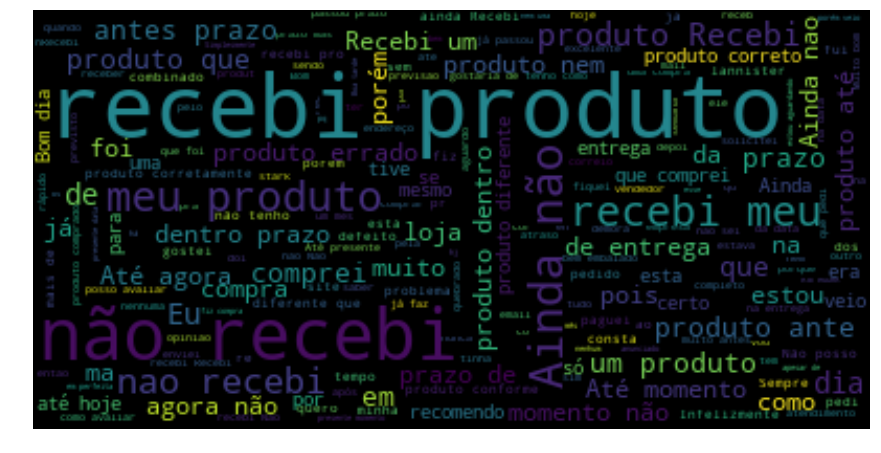

In [93]:
#create dataframe with cluster label 1
text = cleaned_reviews[cleaned_reviews['kMeans'] == 1]['review_comment_message'].to_string()

wordcloud = WordCloud().generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

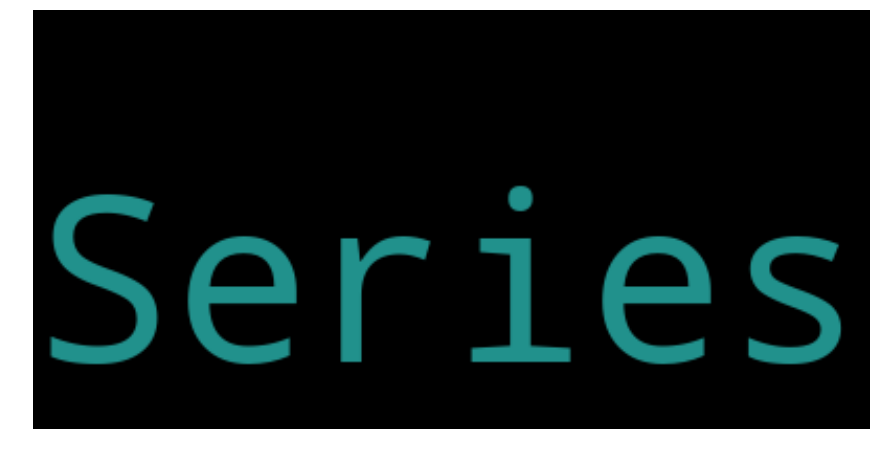

In [94]:
#create dataframe of reviews with cluster label 2
text = cleaned_reviews[cleaned_reviews['kMeans'] == 2]['review_comment_message'].to_string()

#create wordcloud
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

# Conclusion :
customers usaually use review as a medium to let olist know about their thoughts about the overall exprience.<br/>
Another correlation matrix shows that customer review score is closely related to transportaion cost than their satisfacation. <br/>
Trying to find out if the review is positive or negative based on the coupled study of review score and review text will not be successsful because of the mixed trend.<br/> However, these reveiws shows pattern about customer feedback about the overall process staring with product selection, delivery system and if they will recommend it or not.<br/> Since this is a vauge analysis, we can not use these reviews for any further analysis like a recommendation system. However, they are a great tool to understand what are customers' needs.

## sources:
1.  [How to grid search best topic models?](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)
2. [sklearn documentation](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)
3. [Clustering order review comments](https://www.kaggle.com/andradejunior/clustering-order-review-comments)

[**This notebook is MIT liscenced**](https://github.com/anujakapre/E-commerce-Market-Analysis-/blob/master/LICENSE)